In [1]:
from ctypes import *
from typing import List
import cv2
import numpy as np
import vart
import os
import pathlib
import xir
import threading
import time
import sys
import argparse
%matplotlib inline

In [10]:
def load_test_images(path):
    import torch
    import torchvision
    import torchvision.transforms as transforms

    test_transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))])

    test_ds = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=test_transform)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)
    
    imgs = dict()
    
    imgs['data'] = []
    imgs['labels'] = []
    
    for i, data in enumerate(test_loader):
        inputs, labels = data[0].numpy(), data[1].numpy()
        imgs['data'].append(inputs[0])
        imgs['labels'].append(labels仆)
        
    print(imgs['labels'][0])
    import pickle as pk
    
    with open('./data/test_imgs', 'wb') as f:
        pk.dump(imgs, f)
    
    return imgs
            

def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def visualize(imgs):
    import matplotlib.pyplot as plt
    X = imgs['data']
    Y = imgs['labels']
    label_names = load_label_names()
    
    fig, axes1 = plt.subplots(3,3,figsize=(10,10))
    for j in range(3):
        for k in range(3):
            i = np.random.choice(range(len(X)))
            axes1[j][k].set_axis_off()
            axes1[j][k].set_title(label_names[int(Y[i:i+1][0])])
            axes1[j][k].imshow(X[i:i+1][0] * 255)
            
def get_child_subgraph_dpu(graph: "Graph") -> List["Subgraph"]:
    assert graph is not None, "'graph' should not be None."
    root_subgraph = graph.get_root_subgraph()
    assert (root_subgraph is not None), "Failed to get root subgraph of input Graph object."
    if root_subgraph.is_leaf:
        return []
    child_subgraphs = root_subgraph.toposort_child_subgraph()
    assert child_subgraphs is not None and len(child_subgraphs) > 0
    return [
        cs
        for cs in child_subgraphs
        if cs.has_attr("device") and cs.get_attr("device").upper() == "DPU"
    ]


def test(threads, model, img, label):
    divider='---------------------------'
    def runDPU(id,start,dpu,img):

        '''get tensor'''
        inputTensors = dpu.get_input_tensors()
        outputTensors = dpu.get_output_tensors()
        input_ndim = tuple(inputTensors[0].dims)
        output_ndim = tuple(outputTensors[0].dims)

        batchSize = input_ndim[0]
        n_of_images = len(img)
        count = 0
        write_index = start
        while count < n_of_images:
            if (count+batchSize<=n_of_images):
                runSize = batchSize
            else:
                runSize=n_of_images-count

            '''prepare batch input/output '''
            outputData = []
            inputData = []
            inputData = [np.empty(input_ndim, dtype=np.float32, order="C")]
            outputData = [np.empty(output_ndim, dtype=np.float32, order="C")]

            '''init input image to input buffer '''
            for j in range(runSize):
                imageRun = inputData[0]
                imageRun[j, ...] = img[(count + j) % n_of_images].reshape(input_ndim[1:])

            '''run with batch '''
            job_id = dpu.execute_async(inputData,outputData)
            dpu.wait(job_id)

            '''store output vectors '''
            for j in range(runSize):
                out_q[write_index] = np.argmax(outputData[0][j])
                write_index += 1
            count = count + runSize
        
    def app(threads, model, img, label):

        global out_q
        runTotal = img.shape[0]
        out_q = [None] * runTotal
    
        g = xir.Graph.deserialize(model)
        subgraphs = get_child_subgraph_dpu(g)
        all_dpu_runners = []
        for i in range(threads):
            all_dpu_runners.append(vart.Runner.create_runner(subgraphs[0], "run"))

        img = [img[i, :] for i in range(img.shape[0])]
        
        '''run threads '''
        print('Starting',threads,'threads...')
        threadAll = []
        start=0
        for i in range(threads):
            if (i==threads-1):
                end = len(img)
            else:
                end = start+(len(img)//threads)
            in_q = img[start:end]
            t1 = threading.Thread(target=runDPU, args=(i,start,all_dpu_runners[i], in_q))
            threadAll.append(t1)
            start=end

        time1 = time.time()
        for x in threadAll:
            x.start()
        for x in threadAll:
            x.join()
        time2 = time.time()
        timetotal = time2 - time1

        fps = float(runTotal / timetotal)
        print(divider)
        print("Throughput=%.2f fps, total frames = %.0f, time=%.4f seconds" %(fps, runTotal, timetotal))
        
        correct = 0
        wrong = 0
        for i in range(len(out_q)):
            prediction = out_q[i]
            ground_truth = labels[i]
            if (ground_truth==prediction):
                correct += 1
            else:
                wrong += 1
        accuracy = correct/len(out_q)
        print('Correct:%d, Wrong:%d, Accuracy:%.4f' %(correct,wrong,accuracy))

        print(divider)
        return
    
    app(threads, model, img, label)

Files already downloaded and verified
[3]


TypeError: Invalid shape (3, 32, 32) for image data

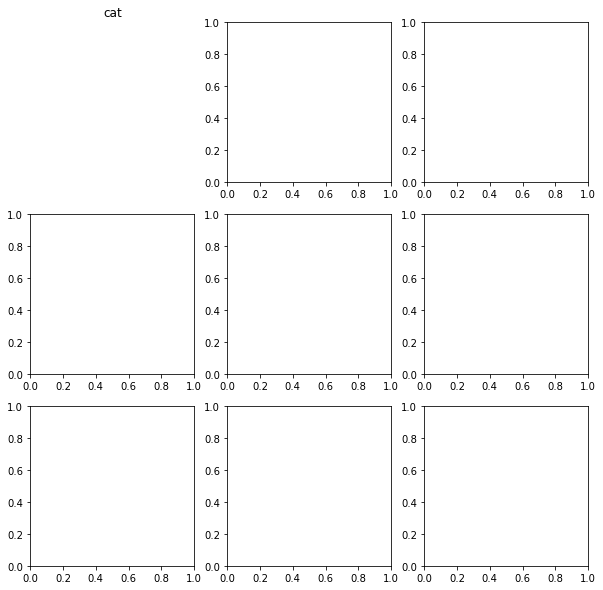

In [11]:
IMG_PATH = './data/cifar-10-batches-py/test_batch'
MODEL_PATH = './deploy/cifarResNet.xmodel'
imgs = load_test_images(IMG_PATH)
visualize(imgs)

In [ ]:
test(4, MODEL_PATH, imgs['data'], imgs['labels'])